In [ ]:
!pip install opencv-python

In [ ]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image, ImageFile
import cv2
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
path = '/content/photo_2024-09-01_12-38-07.jpg'

if 'jpg' not in path:
  image = cv2.imread(path)
  cv2.imwrite('image_converted.jpg', image)
  image = Image.open('image_converted.jpg')
else:
  image = Image.open(path)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
cv2.imwrite('depth_map.png', np.array(depth))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

True

In [ ]:
!pip install open3d

In [ ]:
depth_image = cv2.imread('depth_map.png', cv2.IMREAD_UNCHANGED)
print(depth_image.dtype)
print(depth_image.itemsize*8)

uint8
8


In [ ]:
image_8 = cv2.imread('/content/depth_map.png', cv2.IMREAD_UNCHANGED)
image_16 = np.uint16(image_8) * 256
cv2.imwrite('depth_map16.png', image_16)

True

In [ ]:
import open3d as o3d

image_16 = cv2.imread('/content/depth_map16.png', cv2.IMREAD_UNCHANGED)

depth_image = o3d.geometry.Image(image_16)

height, width = image_16.shape[:2]
intrisnic = o3d.camera.PinholeCameraIntrinsic()
intrisnic.set_intrinsics(width = width, height = height,
                         fx = 500, fy = 500,
                         cx = width/2, cy = height/2)

extrinsic = np.eye(4)

pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_image, intrisnic,
                                                      extrinsic, depth_scale = 1000, depth_trunc =3,
                                                      project_valid_depth_only = True)

vis = o3d.visualization.Visualizer()
vis.create_window(visible = False)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image('rendered_image.png')
vis.distroy_window()
points = np.asarray(pcd.points)

In [ ]:
import open3d as o3d

image_16 = cv2.imread('/content/depth_map16.png', cv2.IMREAD_UNCHANGED)

depth_image = o3d.geometry.Image(image_16)

height, width = image_16.shape[:2]

extrinsic = np.eye(4)

pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_image, o3d.camera.PinholeCameraIntrinsic(),
                                                      extrinsic, depth_scale = 1000, depth_trunc =3,
                                                      project_valid_depth_only = True)

o3d.io.write_point_cloud('output_point_cloud.ply', pcd)
point = np.asarray(pcd.points)

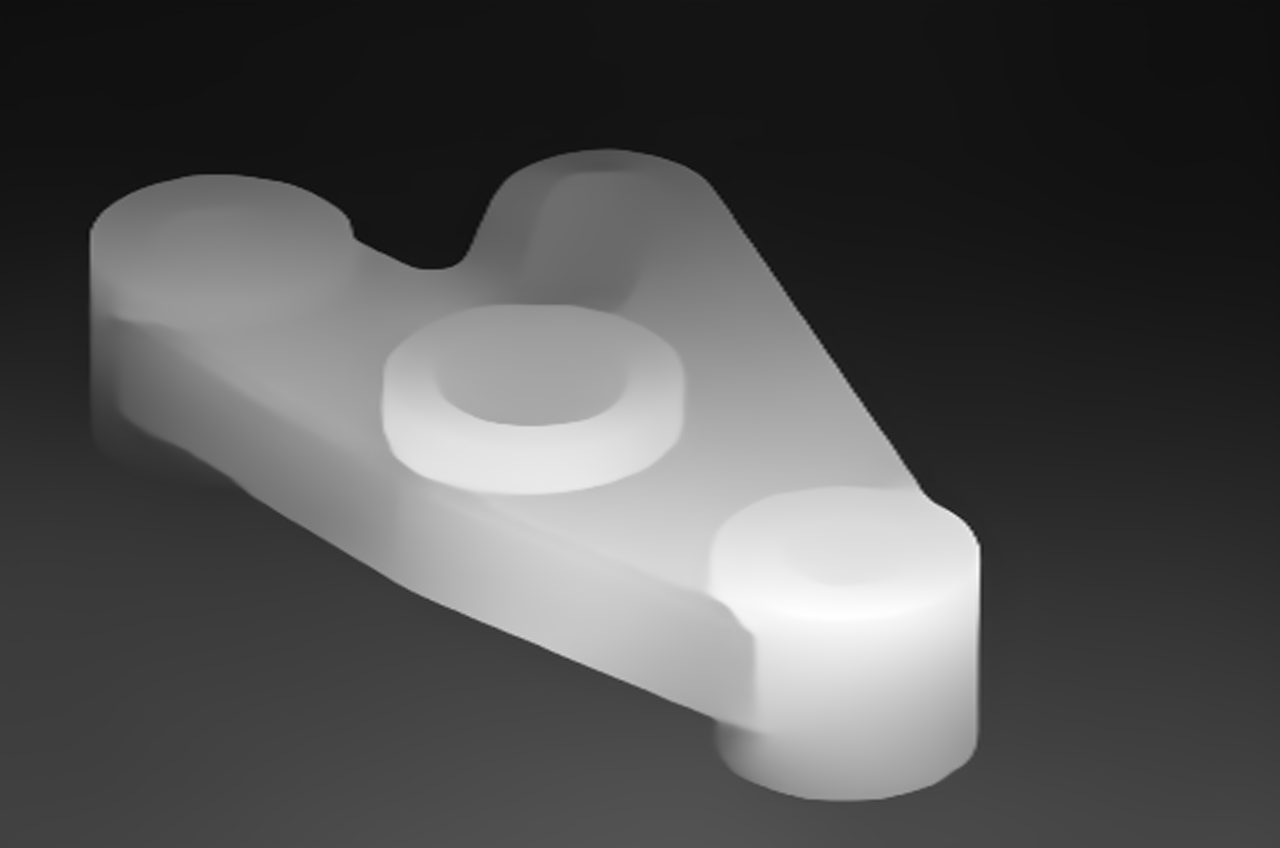

In [ ]:
depth

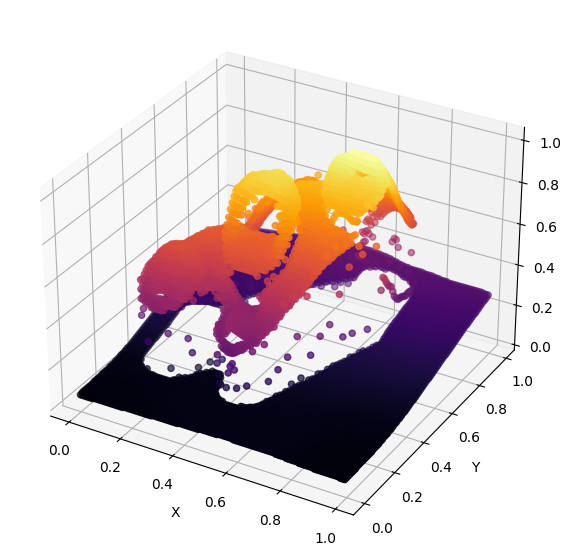

In [ ]:
depth_map = np.array(Image.open('depth_map.png')).astype(np.float32)

depth_map /= np.max(depth_map)

height, width = depth_map.shape
x, y = np.meshgrid(np.arange(width), np.arange(height))

X = x / width
Y = y / height
Z = depth_map

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

step = 10
ax.scatter(X[::step, ::step], Y[::step, ::step], Z[::step, ::step], c=Z[::step, ::step], cmap='inferno')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


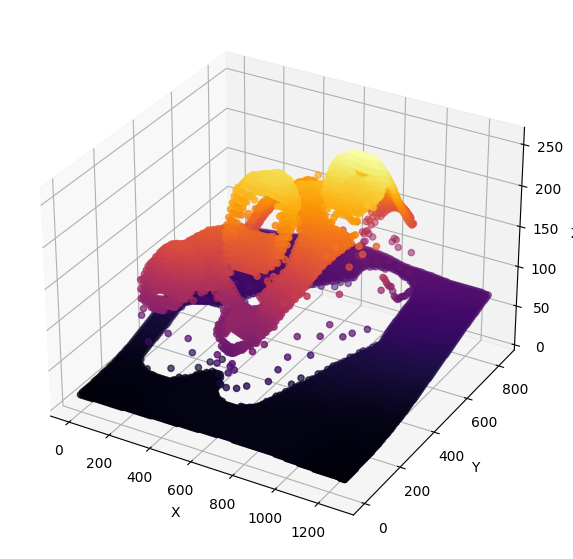

In [ ]:
depth_map = np.array(Image.open('depth_map.png')).astype(np.float32)


depth_map /= np.max(depth_map)

height, width = depth_map.shape

x, y = np.meshgrid(np.arange(width), np.arange(height))

X = x
Y = y
Z = depth_map * 255

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

step = 10
ax.scatter(X[::step, ::step], Y[::step, ::step], Z[::step, ::step], c=Z[::step, ::step], cmap='inferno')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [ ]:
fx = 525.0
fy = 525.0
cx = 319.5
cy = 239.5

def depth_to_point_cloud(depth_map, fx, fy, cx, cy):
    height, width = depth_map.shape
    points = []
    for v in range(height):
        for u in range(width):
            Z = depth_map[v, u] / 1000.0
            X = (u - cx) * Z / fx
            Y = (v - cy) * Z / fy
            points.append((X, Y, Z))
    return np.array(points)

point_cloud = depth_to_point_cloud(depth_map, fx, fy, cx, cy)


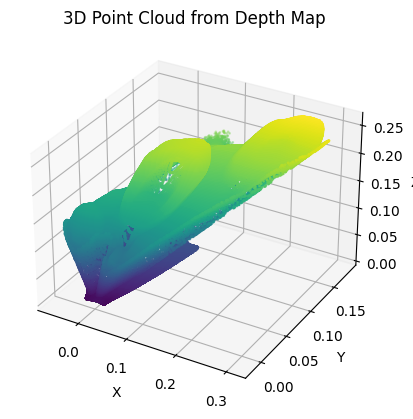

In [ ]:
depth_map = cv2.imread('depth_map.png', cv2.IMREAD_UNCHANGED)

fx = 525.0
fy = 525.0
cx = 319.5
cy = 239.5

def depth_to_point_cloud(depth_map, fx, fy, cx, cy):
    height, width = depth_map.shape
    X, Y, Z = [], [], []
    for v in range(height):
        for u in range(width):
            Z_val = depth_map[v, u] / 1000.0
            X_val = (u - cx) * Z_val / fx
            Y_val = (v - cy) * Z_val / fy
            X.append(X_val)
            Y.append(Y_val)
            Z.append(Z_val)
    return np.array(X), np.array(Y), np.array(Z)

X, Y, Z = depth_to_point_cloud(depth_map, fx, fy, cx, cy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, c=Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Point Cloud from Depth Map')

plt.show()


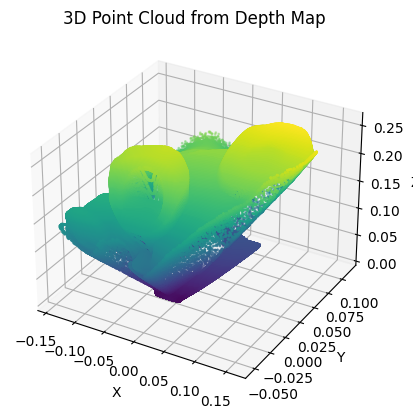

In [ ]:
depth_map = cv2.imread('depth_map.png', cv2.IMREAD_UNCHANGED)

fx = 525.0
fy = 525.0

height, width = depth_map.shape

cx = width / 2.0
cy = height / 2.0

def depth_to_point_cloud(depth_map, fx, fy, cx, cy):
    X, Y, Z = [], [], []
    for v in range(height):
        for u in range(width):
            Z_val = depth_map[v, u] / 1000.0
            X_val = (u - cx) * Z_val / fx
            Y_val = (v - cy) * Z_val / fy
            X.append(X_val)
            Y.append(Y_val)
            Z.append(Z_val)
    return np.array(X), np.array(Y), np.array(Z)

X, Y, Z = depth_to_point_cloud(depth_map, fx, fy, cx, cy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, c=Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Point Cloud from Depth Map')

plt.show()


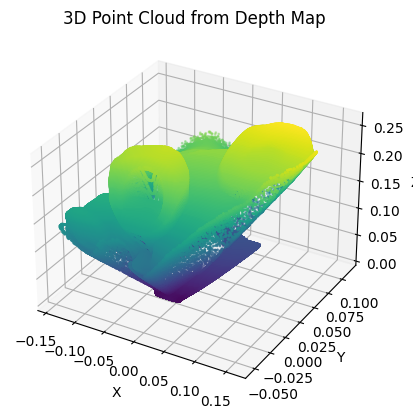

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, c=Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Point Cloud from Depth Map')

plt.show()

In [ ]:
def displace(image, depthmap, coefficient, reference):
    result = image.copy()
    rows, cols, _ = image.shape

    for i in range(cols):
        for j in range(rows):
            depth_value = depthmap[j, i, 0]
            displacement = round(((depth_value - (255 - reference)) / (255 - reference)) * (-coefficient))

            if 0 <= i + displacement < cols:
                result[j, i + displacement] = image[j, i]

    return result

def red(image, depthmap, gray, coefficient, reference):
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    displaced_image = displace(image, depthmap, coefficient, reference)

    result = np.zeros_like(image)
    result[:, :, 2] = displaced_image[:, :, 2]  # Copy red channel

    return result

def project_3d(image, depthmap, d0, angle_x, angle_y, radius):
    rows, cols, _ = image.shape
    result = np.zeros((rows, cols, 4), dtype=np.uint8)

    h = 400.0
    D = 1000
    L = 10000

    x0 = cols / 2
    y0 = rows / 2

    theta_x = np.pi * 2.0 * angle_x / 360
    theta_y = np.pi * 2.0 * angle_y / 360

    camera_x = np.cos(theta_x) * h
    camera_y = np.sin(theta_y) * h

    current_depth = np.full((rows, cols), -d0 - 1, dtype=np.int32)

    for i in range(rows):
        for j in range(cols):
            d = depthmap[i, j, 0] - d0

            tangent_alpha = camera_x / D
            alpha = np.arctan(tangent_alpha)
            tangent_beta = (tangent_alpha * L + camera_x + x0 - j) / (D - d + L)
            beta = np.arctan(tangent_beta)
            gamma = beta - alpha
            x_ref_dbl = L * np.tan(gamma) / np.cos(alpha)
            x_ref_dbl = x0 - x_ref_dbl

            tangent_alpha = camera_y / D
            alpha = np.arctan(tangent_alpha)
            tangent_beta = (tangent_alpha * L + camera_y + y0 - i) / (D - d + L)
            beta = np.arctan(tangent_beta)
            gamma = beta - alpha
            y_ref_dbl = L * np.tan(gamma) / np.cos(alpha)
            y_ref_dbl = y0 - y_ref_dbl

            x_ref = round(x_ref_dbl)
            y_ref = round(y_ref_dbl)

            for x_offset in range(-radius, radius + 1):
                for y_offset in range(-radius, radius + 1):
                    x = x_ref + x_offset
                    y = y_ref + y_offset
                    if 0 <= x < cols and 0 <= y < rows:
                        if d > current_depth[y, x]:
                            color = image[i, j]
                            result[y, x] = [color[0], color[1], color[2], 255]
                            current_depth[y, x] = d

    return cv2.cvtColor(result, cv2.COLOR_BGRA2BGR)

def project_3d(image, depthmap, gray, d0, angle, radius):
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    left_view = project_3d(image, depthmap, d0, angle, 0, radius)
    right_view = project_3d(image, depthmap, d0, 180 - angle, 0, radius)

    result = np.zeros_like(left_view)
    result[:, :, 2] = right_view[:, :, 2]  # Copy red channel

    return result


image = cv2.imread('/content/photo_2024-09-01_12-38-07.jpg')
depthmap = cv2.imread('/content/depth_map.png')

coefficient = 10
reference = 128
d0 = 1000
angle = 20
radius = 5

result = project_3d(image, depthmap, gray=True, d0=d0, angle=angle, radius=radius)
cv2.imwrite('anaglyph_result.png', result)


True